In [125]:
import os
import random
import shutil
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
import evaluate
import mlflow
import mlflow.pyfunc
import gradio as gr

In [189]:
data = r"D:\Work\Internshala\NLP\Imdb - data_imdb.csv"   # <-- path to your CSV (update if needed)
label = "sentiment"                  # column in CSV
text = "review"                      # column in CSV

# Create an organized models directory
models_dir = r"C:\Users\alenp\models"
os.makedirs(models_dir, exist_ok=True)

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
output_dir = os.path.join(models_dir, "bert_sentiment_model")
mlflow_exp_name = "distilbert-sentiment"   
small_subset_size = 2000   # total rows to use
random_seed = 42

In [215]:
# Training hyperparams (tweak for speed)
epochs = 2
train_batch = 8 
eval_batch = 16
lr = 2e-5
max_len = 128

In [217]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [219]:
df = pd.read_csv(data)
print("Raw rows:", len(df))

Raw rows: 50000


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [221]:
df = df[[text, label]].dropna().reset_index(drop=True)

In [222]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [227]:
label_map = {"negative": 0, "positive": 1}
df["label"] = df[label].map(label_map)

In [229]:
subset_size = 5000  # choose smaller number to speed up training
df_small, _ = train_test_split(
    df, 
    train_size=subset_size, 
    stratify=df['label'], 
    random_state=random_seed
)

In [231]:
#split dataset into training and testing
train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=random_seed, stratify=df_small["label"])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("Train rows:", len(train_df), "Test rows:", len(test_df))


Train rows: 4000 Test rows: 1000


In [233]:
# Convert to HuggingFace datasets
train_ds = Dataset.from_pandas(train_df[[text, "label"]])
test_ds = Dataset.from_pandas(test_df[[text, "label"]])
dataset = DatasetDict({"train": train_ds, "test": test_ds})

In [235]:
# tokenizing using  "distilbert-base-uncased" model
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [236]:
def preprocess_function(batch):
    return tokenizer(batch[text], truncation=True, padding="max_length", max_length=max_len)

In [237]:
# Map - tokenizes

dataset = dataset.map(
    preprocess_function, 
    batched=True,
    load_from_cache_file=False
)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [241]:
# set format for Trainer
dataset = dataset.remove_columns([text])
dataset = dataset.with_format("torch")

In [243]:
# Model init
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


In [245]:
# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
roc_auc_metric = evaluate.load("roc_auc")

In [247]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels)["f1"]
    prec = precision_metric.compute(predictions=preds, references=labels)["precision"]
    rec = recall_metric.compute(predictions=preds, references=labels)["recall"]
    try:
        roc = roc_auc_metric.compute(prediction_scores=probs, references=labels)["roc_auc"]
    except Exception:
        roc = None
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec, "roc_auc": roc}

In [249]:
# 5. TrainingArguments & Trainer
# -------------------------
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=train_batch,
    per_device_eval_batch_size=eval_batch,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_strategy="epoch",
    logging_first_step=False,
    seed=random_seed,
    push_to_hub=False,
    dataloader_num_workers=4
)

In [251]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
)

In [253]:
# MLflow experiment setup
# -------------------------
mlflow.set_experiment(mlflow_exp_name)

with mlflow.start_run(nested=False) as run:
    run_id = run.info.run_id
    print("MLflow run id:", run_id)

    # Log parameters
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("train_batch", train_batch)
    mlflow.log_param("eval_batch", eval_batch)
    mlflow.log_param("lr", lr)
    mlflow.log_param("train_rows", len(dataset["train"]))
    mlflow.log_param("eval_rows", len(dataset["test"]))

    # Train
    trainer.train()

    # Evaluate
    eval_metrics = trainer.evaluate(eval_dataset=dataset["test"])
    pprint(eval_metrics)

    # Log metrics to MLflow
    # trainer.evaluate returns keys like 'eval_loss', 'eval_accuracy' etc.
    for k, v in eval_metrics.items():
        if isinstance(v, (int, float)):
            mlflow.log_metric(k, float(v))

    # Save model & tokenizer locally and log as artifact
    model_dir = Path(output_dir) / "final_model"
    if model_dir.exists():
        shutil.rmtree(model_dir)
    model_dir.mkdir(parents=True, exist_ok=True)
    trainer.save_model(model_dir)
    tokenizer.save_pretrained(model_dir)

    # Log model files to MLflow as artifacts
    mlflow.log_artifacts(str(model_dir), artifact_path="distilbert_model")

    # Register model as MLflow artifact (optional: depends on mlflow backend)
    # mlflow.pyfunc.log_model(...)  # optional advanced logging if needed

    print("Model saved to:", model_dir)
    print("Artifacts logged to MLflow run:", run.info.run_id)


MLflow run id: 6325b70fa0ce4614a3a3ae0dad453dc5


C:\Users\alenp\myenv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.372600,0.356133,0.873000,0.874630,0.863548,0.886000,0.940276
2,0.217100,0.508365,0.868000,0.868263,0.866534,0.870000,0.943784


C:\Users\alenp\myenv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\alenp\myenv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'epoch': 2.0,
 'eval_accuracy': 0.873,
 'eval_f1': 0.8746298124383021,
 'eval_loss': 0.3561331033706665,
 'eval_precision': 0.8635477582846004,
 'eval_recall': 0.886,
 'eval_roc_auc': 0.940276,
 'eval_runtime': 215.1883,
 'eval_samples_per_second': 4.647,
 'eval_steps_per_second': 0.293}
Model saved to: C:\Users\alenp\models\bert_sentiment_model\final_model
Artifacts logged to MLflow run: 6325b70fa0ce4614a3a3ae0dad453dc5


In [277]:
mlflow.set_experiment("distilbert-sentiment")

# Get all runs
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("distilbert-sentiment")
runs = client.search_runs(experiment.experiment_id)

# Loop through runs
for run in runs:
    run_id = run.info.run_id
    metrics = client.get_metric_history(run_id, "eval_f1")  # Example metric
    df = pd.DataFrame([(m.step, m.value) for m in metrics], columns=["step", "eval_f1"])
    df.to_csv(f"run_{run_id}_eval_f1.csv", index=False)

Matplotlib is building the font cache; this may take a moment.


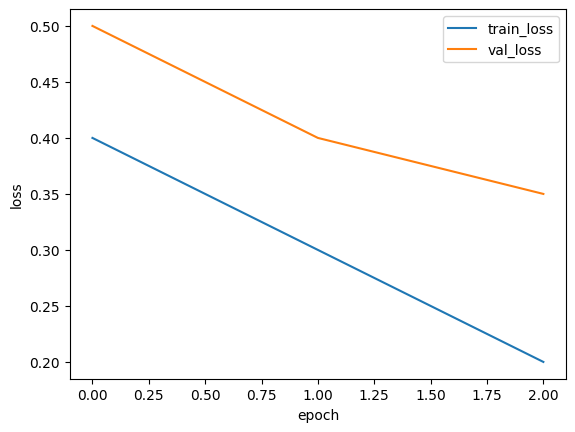

In [279]:
import matplotlib.pyplot as plt

# Example: plot loss
plt.plot([0.4, 0.3, 0.2], label="train_loss")
plt.plot([0.5, 0.4, 0.35], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("loss_plot.png")
mlflow.log_artifact("loss_plot.png", artifact_path="plots")


In [281]:

print(mlflow.get_tracking_uri())


file:///C:/Users/alenp/mlruns


In [283]:
from mlflow.tracking import MlflowClient
import shutil

client = MlflowClient()
run_id = "6325b70fa0ce4614a3a3ae0dad453dc5" 

local_dir = "mlflow_artifacts/run_" + run_id
client.download_artifacts(run_id, "", local_dir)  # "" = root of artifacts


'C:\\Users\\alenp\\mlflow_artifacts\\run_6325b70fa0ce4614a3a3ae0dad453dc5\\'

In [255]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_dir = r"C:\Users\alenp\models\bert_sentiment_model\final_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

sentiment_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Device set to use cpu
C:\Users\alenp\myenv\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [269]:
def predict_sentiment(text):
    out = sentiment_pipe(text[:2000])  # truncate long text
    # out is a list of dicts: [{'label': 'negative', 'score': 0.7}, ...]
    scores = {d['label'].lower(): d['score'] for d in out[0]}  # normalize keys to lowercase
    # pick the label with max score
    pred_label = max(out[0], key=lambda x: x['score'])['label'].lower()
    return {"label": pred_label, "scores": scores}


In [275]:
# Gradio demo
def gradio_predict(text):
    out = predict_sentiment(text)  # returns {"label": ..., "scores": {...}}
    scores = out["scores"]
    label = out["label"]
    
    # Safely get positive and negative scores
    pos_score = scores.get("positive", None)
    neg_score = scores.get("negative", None)
    
    # Fallback in case keys are missing
    if pos_score is None or neg_score is None:
        vals = list(scores.values())
        pos_score = vals[1] if len(vals) > 1 else vals[0]
        neg_score = vals[0]

    return f"Prediction: {label}", f"Positive: {pos_score:.3f}", f"Negative: {neg_score:.3f}"

demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=4, placeholder="Enter a review..."),
    outputs=["text","text","text"],
    title="DistilBERT Sentiment Demo"
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
